In [1]:
import numpy as np
import imageio
import scipy.signal as ss
import cv2
from h5jutils import read_h5j, mip

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'browser'

In [6]:
from scipy import ndimage
import cc3d
from cc3d import connected_components


In [7]:
# # just to visualize the kernel grid and rotated kernel grid 
# basically creates a coordinate plane


# # Parameters
# scale = 1
# windowsize = 8 * 2 * scale + 1  # Calculate window size
# xx, yy = np.meshgrid(
#     np.arange(-(windowsize // 2), windowsize // 2 + 1),  # x-coordinates
#     np.arange(-(windowsize // 2), windowsize // 2 + 1)  # y-coordinates
# )
# points = np.vstack([xx.ravel(), yy.ravel()])  # Stack into points array

# # Visualizing the Kernel Grid
# plt.figure(figsize=(8, 8))
# plt.scatter(points[0], points[1], c="blue", label="Original Grid Points")
# plt.axhline(0, color="red", linestyle="--", label="Center Axes")
# plt.axvline(0, color="red", linestyle="--")
# plt.title("2D Kernel Grid (Original)")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.legend()
# plt.grid(True)
# plt.axis("equal")
# plt.show()

# # Rotating the grid for a specific angle
# angle = 45  # Rotation angle in degrees
# theta = np.radians(angle)
# rotation_matrix = np.array([
#     [np.cos(theta), -np.sin(theta)],
#     [np.sin(theta), np.cos(theta)]
# ])
# rotation_points = rotation_matrix @ points

# # Visualizing Rotated Kernel Grid
# plt.figure(figsize=(8, 8))
# plt.scatter(rotation_points[0], rotation_points[1], c="green", label="Rotated Grid Points")
# plt.axhline(0, color="red", linestyle="--", label="Center Axes")
# plt.axvline(0, color="red", linestyle="--")
# plt.title(f"2D Kernel Grid (Rotated by {angle}°)")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.legend()
# plt.grid(True)
# plt.axis("equal")
# plt.show()


In [34]:
# # Original: Yiyin

# def process_channel(im, const = 0.03, scale=1, min_size=300):
#     blurred = cv2.GaussianBlur(im, (5, 5), 0)
    
#     # Set scale and window size for kernel
#     windowsize = 8 * 2 * scale + 1
#     xx, yy = np.meshgrid(np.arange(-(windowsize//2), windowsize//2 + 1), #(x,y)
#                          np.arange(-(windowsize//2), windowsize//2 + 1))
#     points = np.vstack([xx.ravel(), yy.ravel()]) # ravel flattens array (makes into 1D (row))
    
#     angles = np.arange(0, 180, 180/8)
#     sigma1 = 2.9 * scale         # sigma is st.dev
#     sigma2 = 0.5 * scale
    
#     outputs = np.zeros([len(angles)] + list(im.shape)) # initiate 3D array (
#     for i, angle in enumerate(angles):
#         theta = np.radians(angle) # converts from degrees to radians
#         rotation_matrix = np.array([
#             [np.cos(theta), -np.sin(theta)],
#             [np.sin(theta), np.cos(theta)]
#         ])
#         rotation_points = rotation_matrix @ points #multiplying by rot matrix transforms xy coordinates in window
        
#         X_rot = rotation_points[0].reshape(xx.shape) 
#         Y_rot = rotation_points[1].reshape(yy.shape)
        
#         kernel = np.exp(-(X_rot**2)/(2*sigma1**2)- (Y_rot**2) / (2*sigma2**2))  # results in gaussian kernel to achieve blur
#         kernel /= kernel.sum()  
    
#         output = ss.fftconvolve(blurred, kernel, mode='full') # convolve blurred image with gaussian kernel 
#         outputs[i] = output[windowsize//2:-(windowsize//2), windowsize//2:-(windowsize//2)] #3D array
    
#     binary_mask = (blurred > (outputs.min(axis=0) + const)).astype(np.uint8)  # binary threshold # can adjust constant value # changed from 15 to 2
    
#     # define connected components to rid noise
#     num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    
#     filtered_mask = np.zeros_like(binary_mask)
#     for i in range(1, num_labels):
#         if stats[i, cv2.CC_STAT_AREA] >= min_size:
#             filtered_mask[labels == i] = 1

#     return filtered_mask, binary_mask, blurred

In [35]:

signal, _, att = read_h5j('/Users/sarahbinder/Desktop/Grad School/GA Project/Data Files/R27C09-20181221_62_F1-f-40x-central-GAL4-JRC2018_FEMALE_40x-aligned_stack.h5j',
                          channels = 'G') 

# signal, _, att = read_h5j('R27C09/R27C09-20181221_62_F1-f-40x-central-GAL4-JRC2018_FEMALE_40x-aligned_stack.h5j')

# Gen1 MCFO
# signal, _, att = read_h5j('R28E11-20190702_65_G3-f-40x-central-GAL4-JRC2018_FEMALE_40x-aligned_stack.h5j')

# Split Gal4 Omnibus
# signal, _, att = read_h5j('SS00837-20230210_46_A3-f-20x-brain-Split_GAL4-JRC2018_FEMALE_20x_HR-aligned_stack.h5j')

# Split Gal4 Omnibus
# signal, _, att = read_h5j('SS01580-20191127_42_E5-f-20x-brain-Split_GAL4-JRC2018_FEMALE_20x_HR-aligned_stack.h5j')



In [36]:
# this line makes it 2D
im = mip(signal / (4095 if signal.dtype == np.uint16 else 255))[:,:,0]

#signal is an array that contains the loaded image data. if it has 3 channels, it will be a 3D array (hxWxchannels) 
# divigind signal normalizes pixel valyes based on the data type
# mip processes the signal by computing MIP across a specific axis
# [:,:,0] makes im a 2D array (just height and width)

# read_h5j function allows me to pecify which channel to load using the channels parameter (or all) (R G B or Y wi think when its only one channel in split gal4)
# if all channels were loaded, signal would have dimensions Nz x H x W x 3 , representing the stack of RGB images

# one channel DOES NOT correspond to one slice
# slices represents the number of 2D images in a stack
# vs. channels represent different colors
# each slice has all the channels.. for each slive i, you can access a H x W x Channel matrix
# the code currently processes all slices for one channel

In [10]:
im.shape

(664, 1432)

In [ ]:
# this would be for reading in the image in 3D

# reading all slices and channels
signal, _, att = read_h5j(filename, channels='RGB') # signal.shape (Nz,H,W,3) # 4D array

# normalize pixel intensities for all channels
im = signal / (4095 if signal.dtype == np.uint16 else 255)



In [11]:
#from scipy import ndimage
gaussian_blur = ndimage.gaussian_filter1d(im, sigma=3)
gaussian_blur.shape

(664, 1432)

In [12]:
blurred = cv2.GaussianBlur(im, (5, 5), 0)
blurred.shape

(664, 1432)

In [42]:
# pkg adaptation # still for 2D first

def process_channel_adapted(im, const = 0.03, scale=1, min_size=300):
    #blurred = cv2.GaussianBlur(im, (5, 5), 0)
    gaussian_blur = ndimage.gaussian_filter1d(im, sigma=3) # creates a 1D array
    
    # Set scale and window size for kernel
    windowsize = 8 * 2 * scale + 1
    xx, yy = np.meshgrid(np.arange(-(windowsize//2), windowsize//2 + 1), #(x,y)
                         np.arange(-(windowsize//2), windowsize//2 + 1))
    points = np.vstack([xx.ravel(), yy.ravel()]) # ravel flattens array (makes into 1D (row))
    
    angles = np.arange(0, 180, 180/8) # in 3D, 2 angles because theres 3 directions (starting, 1 rotaton, 2nd roatioan)
    sigma1 = 2.9 * scale         # sigma is st.dev
    sigma2 = 0.5 * scale
    
    outputs = np.zeros([len(angles)] + list(im.shape)) # initiate 3D array (
    for i, angle in enumerate(angles):
        theta = np.radians(angle) # converts from degrees to radians
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)] # need 3x3 rotation matrix, phi in addition to theta
        ])
        rotation_points = rotation_matrix @ points #multiplying by rot matrix transforms xy coordinates in window
        
        X_rot = rotation_points[0].reshape(xx.shape) 
        Y_rot = rotation_points[1].reshape(yy.shape)
        
        kernel = np.exp(-(X_rot**2)/(2*sigma1**2)- (Y_rot**2) / (2*sigma2**2))  # results in gaussian kernel to achieve blur
        kernel /= kernel.sum()  
    
        output = ss.fftconvolve(blurred, kernel, mode='full') # convolve blurred image with gaussian kernel 
        outputs[i] = output[windowsize//2:-(windowsize//2), windowsize//2:-(windowsize//2)] #3D array
    
    binary_mask = (blurred > (outputs.min(axis=0) + const)).astype(np.uint8)  # binary threshold # can adjust constant value # changed from 15 to 2
    
    # define connected components to rid noise
    # num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    labels_out, N = cc3d.connected_components(binary_mask, connectivity=8, return_N=True) 
   
    filtered_mask = np.zeros_like(binary_mask)
    for i in range(1, N):
        area = np.sum(labels_out == i) # calc area of connected component # in this pkg, labels array contains int label denoting to which CC it belongs
        if area >= min_size:
            filtered_mask[labels_out == i] = 1
    #     if stats[i, cv2.CC_STAT_AREA] >= min_size:
    #         filtered_mask[labels == i] = 1
    
    return filtered_mask, binary_mask, gaussian_blur 

In [29]:
# fig = plt.figure(figsize = (18,8))
# plt.imshow(im, cmap='gray', vmax = 0.2)

In [43]:
#filtered_mask, binary_mask, blurred = process_channel(im, const = 0.02, scale = 1, min_size = 400)

filtered_mask, binary_mask, gaussian_blur = process_channel_adapted(im, const = 0.02, scale = 1, min_size = 400)

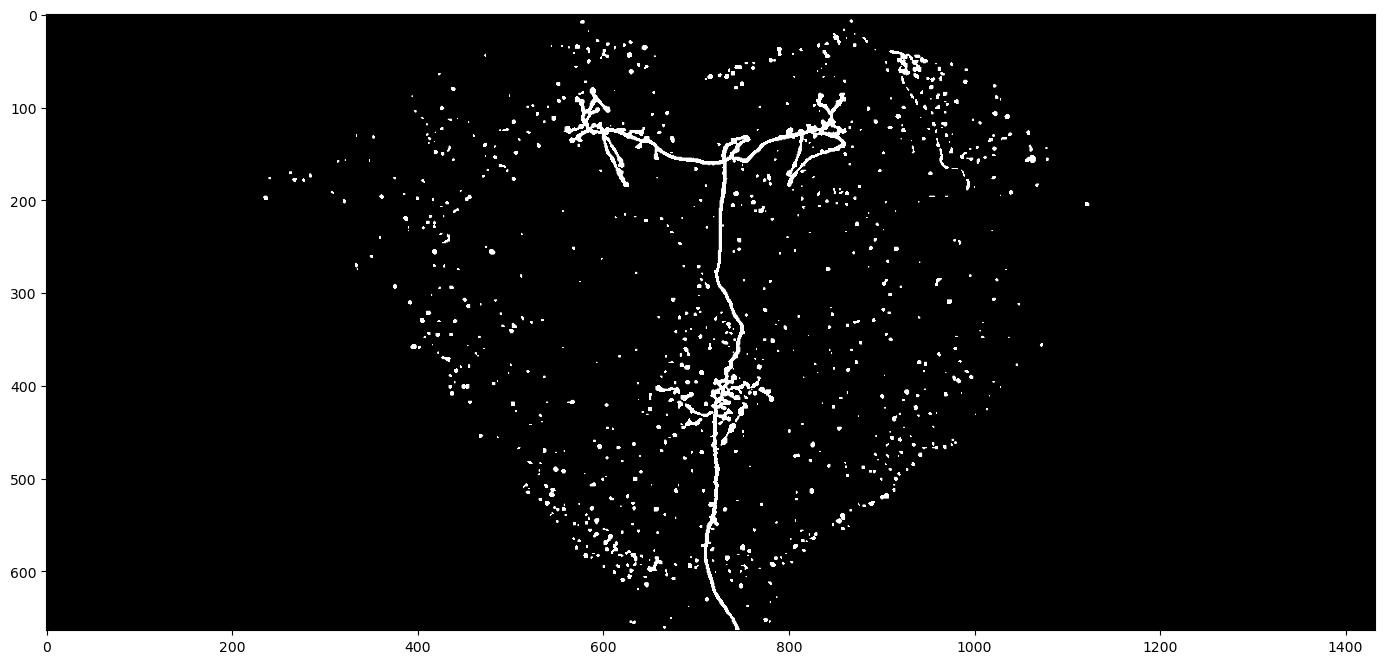

In [44]:
fig = plt.figure(figsize = (18,8))
plt.imshow(binary_mask, cmap = 'gray', vmax = 0.3)

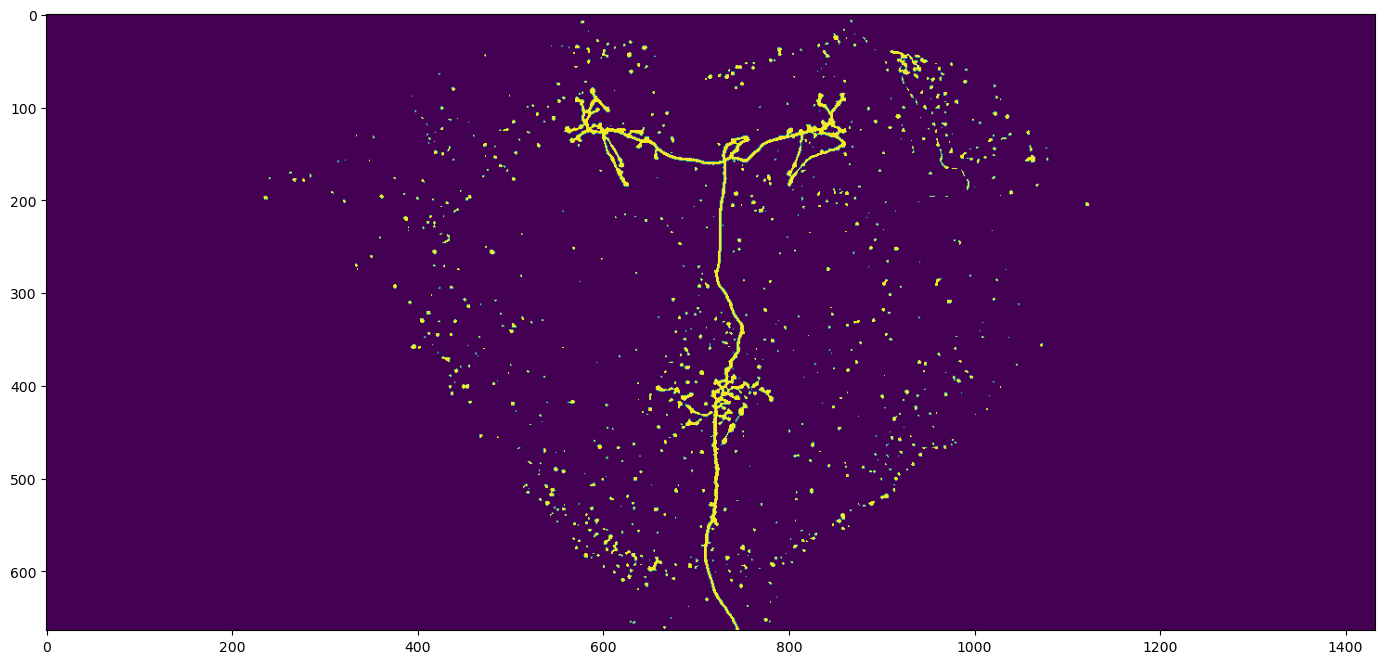

In [45]:
fig = plt.figure(figsize = (18,8))
plt.imshow(binary_mask)

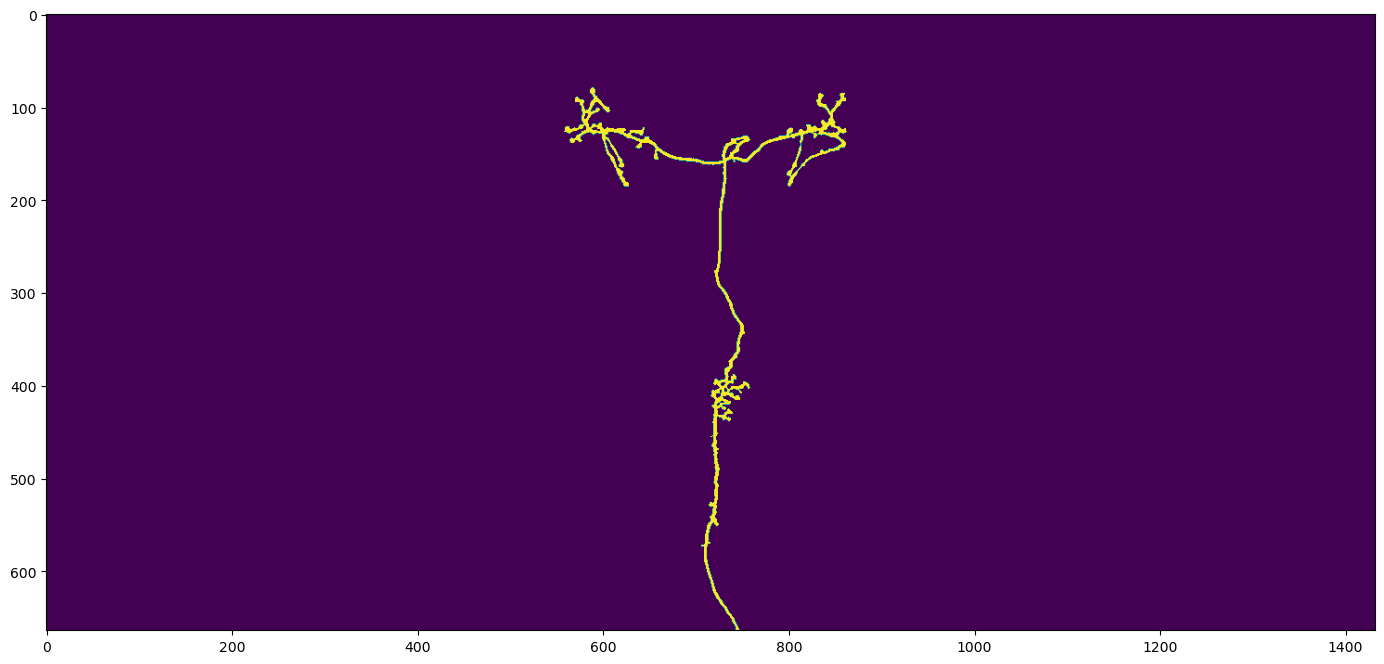

In [46]:
fig = plt.figure(figsize = (18,8))
plt.imshow(filtered_mask)